# MFI (Money Flow Index) Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### MFI approach
* MFI is volume weighted RSI.
* Typical Price : (high + low + close) / 3
* MF (Money Flow) : Typical Price * volume
* MFR (Money Flow Ratio) = Positive Money Flow / Negative Money Flow
* MFI = 100 -  ( 100 / (1 + MFI ))
* If MFI <= 20 buy, else MFI >= 80 sell.
* Of course this (20,80) can be adjusted like (30,70) or (10, 90) and so on.

In [2]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [3]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [4]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [5]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [76]:
def MFI(pr_df, ndays=14):
    pr = pr_df.copy()
    pr['TypicalPrice'] = round((pr['high']+pr['low']+pr['adjprice'])/3,3)
    pr['MF'] = pr['TypicalPrice'] * pr['volume']
    
    P_flow = []
    N_flow = []
    P_flow.append(0)
    N_flow.append(0)
    
    for i in range(1, len(pr)):
        if pr['TypicalPrice'][i] > pr['TypicalPrice'][i-1]:
            P_flow.append(pr['MF'][i])
            N_flow.append(0)
        elif pr['TypicalPrice'][i] < pr['TypicalPrice'][i-1]:
            N_flow.append(pr['MF'][i])
            P_flow.append(0)
        else :
            P_flow.append(0)
            N_flow.append(0)
    pr['P_MF'] = P_flow
    pr['N_MF'] = N_flow
    pr['P_MF'] = pr['P_MF'].rolling(ndays,min_periods=1).sum()
    pr['N_MF'] = pr['N_MF'].rolling(ndays,min_periods=1).sum()
    pr['MFI'] = 100 * (pr['P_MF'] / (pr['P_MF'] + pr['N_MF']))
    return pr

In [28]:
 def MFI_Signal(dff, buyMFI=20, sellMFI=80):
    df = dff.copy()
    Buy = []
    Sell = []
    flag = -1
    for i in range(len(df)):
        if df['MFI'][i] <= buyMFI and flag != 1:
            Buy.append(df['adjprice'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['MFI'][i] >= sellMFI and flag != 0:
            Sell.append(df['adjprice'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [49]:
 def MFI_Signal_All(dff, buyMFI=20, sellMFI=80):
    df = dff.copy()
    Buy = []
    Sell = []
    for i in range(len(df)):
        if df['MFI'][i] <= buyMFI:
            Buy.append(df['adjprice'][i])
            Sell.append(np.nan)
        elif df['MFI'][i] >= sellMFI:
            Sell.append(df['adjprice'][i])
            Buy.append(np.nan)
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    return df

In [43]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [98]:
def MFI_Run(start, end, code, ndays=14, buyMFI=30, sellMFI=70, doplot=True):
    pr = ldr.GetPricelv1(start, end, [code])
    pr = pr.sort_values(by=['DATE'])
    pr.index = pr['DATE'].to_list()
    pr = pr.drop(['DATE','OPEN','CODE'],axis=1)
    mfi = MFI(pr, ndays=ndays)
    if doplot :
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,6))
        plt.plot(mfi.reset_index().index, mfi['MFI'],label='MFI',color='gray')
        plt.axhline(10, linestyle='--', color='orange')
        plt.axhline(buyMFI, linestyle='--', color='blue')
        plt.axhline(sellMFI, linestyle='--', color='blue')
        plt.axhline(90, linestyle='--', color='orange')
        plt.title("MFI indicator for {}".format(code))
    mfi_sig = MFI_Signal(mfi, buyMFI=buyMFI, sellMFI=sellMFI)
    #mfi_sig_all = MFI_Signal_All(mfi, buyMFI=buyMFI, sellMFI=sellMFI)
    mfi_sig_all = mfi_sig
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(mfi_sig_all.index, mfi_sig_all['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(mfi_sig_all.index, mfi_sig_all['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(mfi_sig_all['adjprice'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('MFI on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    mfi_sig = mfi_sig.rename(columns={'adjprice':'close'})
    _, rst = BackTest(mfi_sig)
    rst.index = [code]
    return rst

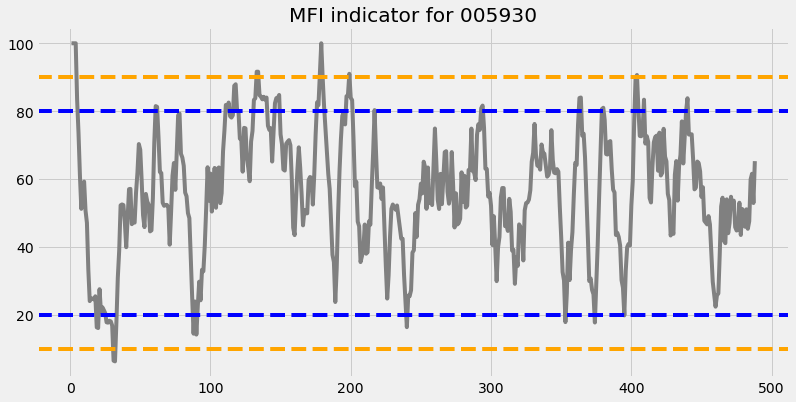

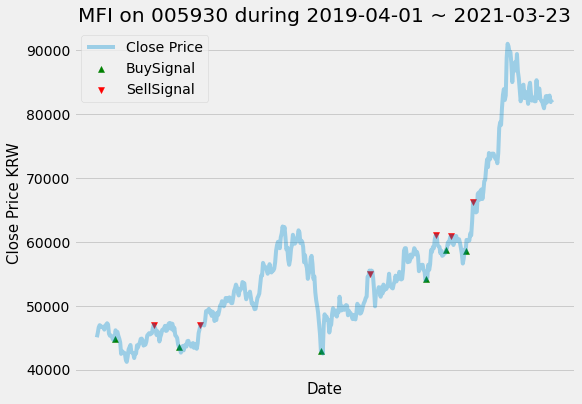

Wall time: 2.09 s


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.91,1,0.28,0.04,0.32,1.12,1.11,6,2.69


In [99]:
%%time
MFI_Run('2019-04-01','2021-03-23','005930',10,20,80,True)

In [89]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,MFI_Run(start, end, cd,10,20,80,False)])

Wall time: 6.05 s


In [90]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.91,1,0.28,0.04,0.32,1.12,1.11,6,2.69
005935,1.49,0.8,0.15,-0.04,0.33,1.09,1.08,5,1.84
034220,0.93,0.75,0.09,-0.24,0.6,0.99,0.98,4,-0.36
066570,0.76,0.5,0.11,-0.25,0.23,0.95,0.93,4,-0.74


### Conclusion
* HitRatio is better than other indicators but other indexes are not generally good.
* For instance, SAMSUNG is well predicted but LG groups are not well predicted.
* So MFI can be used as a complementary indicator.